In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import roc_auc_score, log_loss
from methods import *

In [2]:
%load_ext autoreload
%autoreload 2

In [5]:
def read_features(path, arch_to_select=None):
    report = pd.read_csv(path)
    if arch_to_select is not None:
        report = report[report['model_architecture'] == arch_to_select]
    report['diff_mean'] = abs(report['clean_mean'] - report['backd_mean'])
    report['diff_std'] = abs(report['clean_std'] - report['backd_std'])
    features = report[['diff_mean', 'diff_std']].values
    labels = np.array([int(report['model_label'].iloc[i] == 'backdoor') for i in range(len(report))])
    return features, labels

def evaluate_classifier(train_x, train_y, test_x, test_y):
    clf = svm.SVC(kernel='linear', probability=True)
    clf.fit(train_x, train_y)
    y_score = clf.predict(test_x)
    y_pred = clf.predict_proba(test_x)
    roc_auc = roc_auc_score(y_true=test_y, y_score=y_score)
    cross_entropy = log_loss(y_true=test_y, y_pred=y_pred)
    return roc_auc, cross_entropy

# NEW CODE

## show (size vs ROC) plots for training and holdout for individual architectures

############# round1-dataset-train #############


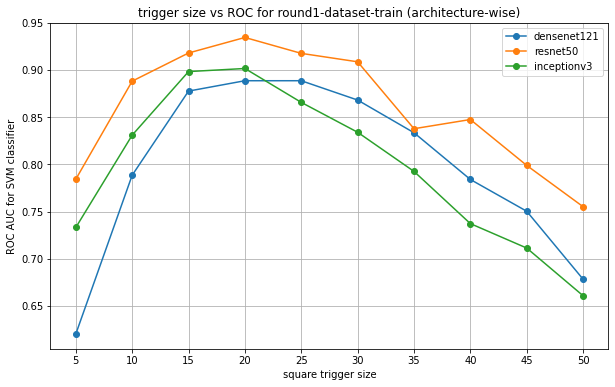

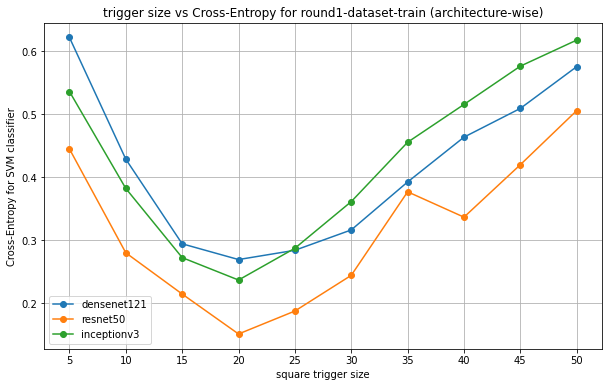

############# round1-holdout-dataset #############


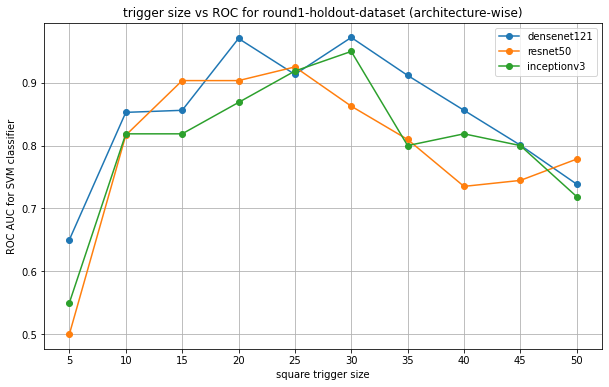

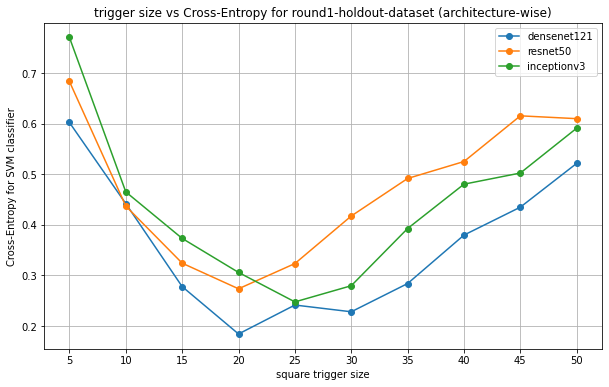

In [8]:
list_square_sizes = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
list_archs = ['densenet121', 'resnet50', 'inceptionv3']

for dataset in ['round1-dataset-train', 'round1-holdout-dataset']:
    roc_auc_scores = {arch:[] for arch in list_archs}
    xent_scores = {arch:[] for arch in list_archs}
    for square_size in list_square_sizes:
        for arch in list_archs:
            path = f'confusion-reports/ics_svm/{dataset}/{dataset}_custom-square-size-{square_size}_backd-original-color_clean-black-color.csv'
            X, y = read_features(path, arch)
            roc, xent = evaluate_classifier(X, y, X, y)
            roc_auc_scores[arch].append(roc)
            xent_scores[arch].append(xent)
    
    print('#############', dataset, '#############')
    # PLOT ROC
    plt.figure(figsize=(10, 6)).patch.set_color('white')
    for arch in roc_auc_scores.keys():
        plt.plot(list_square_sizes, roc_auc_scores[arch], 'o-', label=arch)
    plt.grid()
    plt.legend()
    plt.xlabel('square trigger size')
    plt.ylabel('ROC AUC for SVM classifier')
    plt.xticks(list_square_sizes)
    plt.title(f'trigger size vs ROC for {dataset} (architecture-wise)')
    plt.show()
    
    # PLOT XENT
    plt.figure(figsize=(10, 6)).patch.set_color('white')
    for arch in roc_auc_scores.keys():
        plt.plot(list_square_sizes, xent_scores[arch], 'o-', label=arch)
    plt.grid()
    plt.legend()
    plt.xlabel('square trigger size')
    plt.ylabel('Cross-Entropy for SVM classifier')
    plt.xticks(list_square_sizes)
    plt.title(f'trigger size vs Cross-Entropy for {dataset} (architecture-wise)')
    plt.show()

## show (size vs ROC) plots for training and holdout using all architectures as a whole

############# round1-dataset-train #############


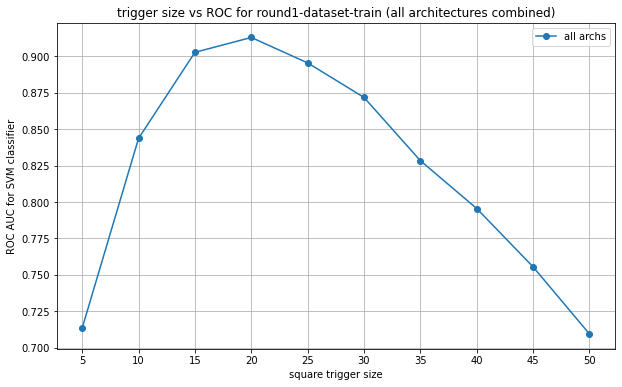

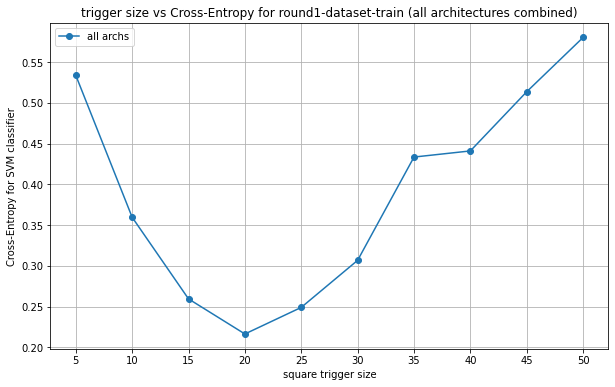

############# round1-holdout-dataset #############


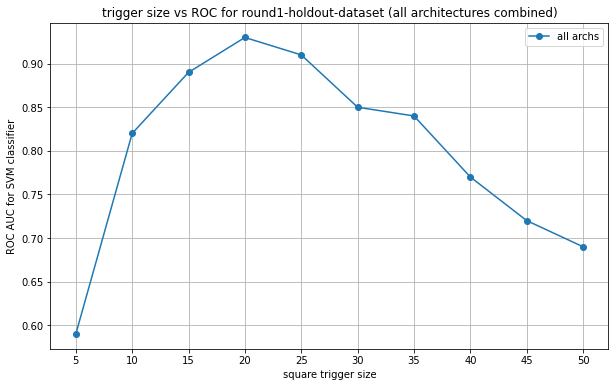

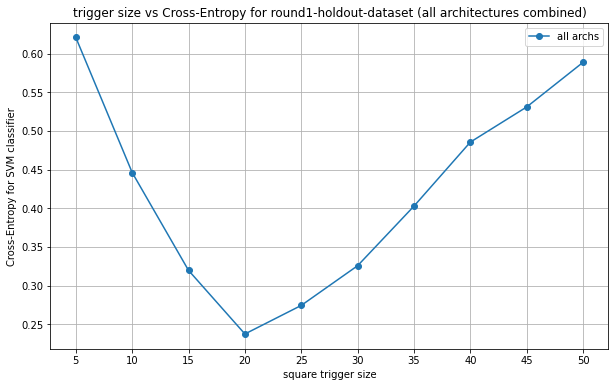

In [10]:
list_square_sizes = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
list_archs = ['densenet121', 'resnet50', 'inceptionv3']

for dataset in ['round1-dataset-train', 'round1-holdout-dataset']:
    roc_auc_scores = []
    xent_scores = []
    for square_size in list_square_sizes:
        path = f'confusion-reports/ics_svm/{dataset}/{dataset}_custom-square-size-{square_size}_backd-original-color_clean-black-color.csv'
        X, y = read_features(path)
        
        roc, xent = evaluate_classifier(X, y, X, y)
        roc_auc_scores.append(roc)
        xent_scores.append(xent)
        
    print('#############', dataset, '#############')
    plt.figure(figsize=(10, 6)).patch.set_color('white')
    plt.plot(list_square_sizes, roc_auc_scores, 'o-', label='all archs')
    plt.grid()
    plt.legend()
    plt.xlabel('square trigger size')
    plt.ylabel('ROC AUC for SVM classifier')
    plt.xticks(list_square_sizes)
    plt.title(f'trigger size vs ROC for {dataset} (all architectures combined)')
    plt.show()
    
    plt.figure(figsize=(10, 6)).patch.set_color('white')
    plt.plot(list_square_sizes, xent_scores, 'o-', label='all archs')
    plt.grid()
    plt.legend()
    plt.xlabel('square trigger size')
    plt.ylabel('Cross-Entropy for SVM classifier')
    plt.xticks(list_square_sizes)
    plt.title(f'trigger size vs Cross-Entropy for {dataset} (all architectures combined)')
    plt.show()

## train an SVM classifier on training with trigger_size=S and test it on holdout data with trigger_size=S

In [12]:
for square_size in list_square_sizes:
    path_train = f'confusion-reports/ics_svm/round1-dataset-train/round1-dataset-train_custom-square-size-{square_size}_backd-original-color_clean-black-color.csv'
    path_holdout = f'confusion-reports/ics_svm/round1-holdout-dataset/round1-holdout-dataset_custom-square-size-{square_size}_backd-original-color_clean-black-color.csv'
    
    X_train, y_train = read_features(path_train)
    X_holdout, y_holdout = read_features(path_holdout)
    
    final_roc, final_xent = evaluate_classifier(X_train, y_train, X_holdout, y_holdout)
    print(f'size {square_size}: roc={final_roc:.4f}, xent={final_xent:.4f}')

size 5: roc=0.6400, xent=0.6388
size 10: roc=0.7800, xent=0.4760
size 15: roc=0.8800, xent=0.3203
size 20: roc=0.9200, xent=0.2405
size 25: roc=0.9200, xent=0.2815
size 30: roc=0.9000, xent=0.3308
size 35: roc=0.8200, xent=0.4096
size 40: roc=0.7300, xent=0.4843
size 45: roc=0.7200, xent=0.5509
size 50: roc=0.6700, xent=0.5972


# OLD CODE, NOT USED ANYMORE

In [ ]:
# list_square_sizes = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
# roc_auc_scores = []
# list_roc_auc_scores = {'densenet121':[], 'resnet50':[]}
# for square_size in list_square_sizes:
#     plt.figure(figsize=(20, 8)).patch.set_color('white')
#     n_plot = 0
#     big_X, big_Y = None, None
#     for arch in ['densenet121', 'resnet50']:
#         path = f'confusion-reports/ics_fully_connected/round1-holdout-dataset_{arch}_custom-square-size-{square_size}_backd-original-color_clean-black-color.csv'
#         # path = f'confusion-reports/round1-holdout-dataset_custom-square-size-{square_size}_backd-black-color_clean-black-color.csv'
#         # path = f'confusion-reports/round1-holdout-dataset_custom-square-size-{square_size}_backd-original-color_clean-black-color.csv'
        
#         # path = f'confusion-reports/round1-holdout-dataset_sqrt-size_backd-black-color_clean-black-color.csv'
#         # path = f'confusion-reports/round1-holdout-dataset_sqrt-size_backd-original-color_clean-black-color.csv'
        
#         # path = f'confusion-reports/round1-holdout-dataset_original-size_backd-black-color_clean-black-color.csv'
#         # path = f'confusion-reports/round1-holdout-dataset_original-size_backd-original-color_clean-black-color.csv'
#         report = pd.read_csv(path)
#         # report['model_label'] = report['model_label'].apply(lambda s: {'clean':0, 'backdoor':1}[s])
#         report['diff_mean'] = abs(report['clean_mean'] - report['backd_mean'])
#         report['diff_std'] = abs(report['clean_std'] - report['backd_std'])
#     #     X = report[['diff_mean', 'diff_std']].values
#     #     plot2D(X, x='diff_mean', y='diff_std', labels=report['model_label'], title=f'square_size = {square_size}')
#         X = report[['diff_mean', 'diff_std']].values
#         Y = np.array([int(report['model_label'].iloc[i] == 'backdoor') for i in range(len(report))])
#         if big_X is None and big_Y is None:
#             big_X = np.copy(X)
#             big_Y = np.copy(Y)
#         else:
#             big_X = np.vstack((big_X, X))
#             big_Y = np.hstack((big_Y, Y))
#     # end for
#     clf = svm.SVC(kernel='linear')
#     clf.fit(big_X, big_Y)
#     roc_auc = roc_auc_score(y_true=big_Y, y_score=clf.predict(big_X))
#     roc_auc_scores.append(roc_auc)
# #     list_roc_auc_scores[arch].append(roc_auc)

#     x_min = -0.1
#     x_max = big_X[:,0].max() + 0.5
#     y_min = -0.1
#     y_max = big_X[:,1].max() + 0.5

#     w = clf.coef_[0]
#     a = -w[0] / w[1]
#     xx = np.linspace(x_min, x_max)
#     yy = a * xx - (clf.intercept_[0]) / w[1]

#     margin = 1 / np.sqrt(np.sum(clf.coef_ ** 2))
#     yy_down = yy - np.sqrt(1 + a ** 2) * margin
#     yy_up = yy + np.sqrt(1 + a ** 2) * margin
        
# #     n_plot += 1
# #     plt.subplot(1, 2, n_plot)
#     plt.figure(figsize=(8, 6)).patch.set_color('white')
#     plt.plot(xx, yy, 'k-')
#     plt.plot(xx, yy_down, 'k--')
#     plt.plot(xx, yy_up, 'k--')
#     plt.xlim(x_min, x_max)
#     plt.ylim(y_min, y_max)

#     plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=80, facecolors='none', zorder=10, edgecolors='k')
#     plt.scatter(big_X[:, 0], big_X[:, 1], c=big_Y, zorder=10, cmap=plt.cm.Paired, edgecolors='k')
#     plt.title(f'resnet+densenet: size = {square_size} | margin = {margin:.3f} |  ROC = {roc_auc:.3f}')
#     plt.grid()
#     plt.show()
#     print('------------------------------------------------------------------------------------------------------------------------')
# plt.figure(figsize=(12, 8)).patch.set_color('white')
# # plt.plot(list_square_sizes, list_roc_auc_scores['densenet121'], 'o-', label='densenet')
# # plt.plot(list_square_sizes, list_roc_auc_scores['resnet50'], 'o-', label='resnet')
# plt.plot(list_square_sizes, roc_auc_scores, 'o-')
# plt.grid()
# plt.legend()
# plt.xlabel('square trigger side size')
# plt.ylabel('ROC AUC for SVM')
# plt.xticks(list_square_sizes)
# plt.title('densenet and resnet aggregated by trigger size')
# # plt.title('Trigger Size vs ROC AUC for models resnet, densenet')

# Train SVM on DenseNet training and report ROC score on holdout data, for all trigger sizes

In [ ]:
# arch = 'densenet121'
# sizes = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

# n_results = 0
# results = pd.DataFrame(columns=['train_sq_size', 'holdout_sq_size', 'roc_train_only', 'roc_holdout_only', 'roc_train_holdout'])

# for train_sq_size in sizes:
#     path_train = f'confusion-reports/round1-dataset-train_{arch}_custom-square-size-{train_sq_size}_backd-original-color_clean-black-color.csv'
    
#     X_train, y_train = read_features(path_train)
#     roc_train_only = evaluate_classifier(X_train, y_train, X_train, y_train)
    
#     for holdout_sq_size in sizes:
#         path_holdout = f'confusion-reports/round1-holdout-dataset_{arch}_custom-square-size-{holdout_sq_size}_backd-original-color_clean-black-color.csv'
        
#         X_holdout, y_holdout = read_features(path_holdout)
        
#         roc_holdout_only = evaluate_classifier(X_holdout, y_holdout, X_holdout, y_holdout)
#         roc_train_holdout = evaluate_classifier(X_train, y_train, X_holdout, y_holdout)
        
#         results.loc[n_results] = [train_sq_size, holdout_sq_size, roc_train_only, roc_holdout_only, roc_train_holdout]
#         n_results += 1
# print('done')

In [ ]:
results.to_csv('confusion-reports/results-densenet-train-vs-holdout.csv', index=False)

# Plot DenseNet ROC scores

In [ ]:
# sizes = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
# train_rocs   = [0.60, 0.79, 0.88, 0.91, 0.89, 0.87, 0.84, 0.84, 0.80, 0.75]
# holdout_rocs = [0.65, 0.76, 0.88, 0.91, 0.91, 0.95, 0.95, 0.88, 0.91, 0.74]
# plt.figure(figsize=(12, 8)).patch.set_color('white')
# plt.plot(sizes, train_rocs, 'o-', label='training data ROC')
# plt.plot(sizes, holdout_rocs, 'o-', label='holdout data ROC')
# plt.grid()
# plt.legend()
# plt.xlabel('square trigger side size')
# plt.ylabel('ROC AUC for SVM')
# plt.xticks(sizes)
# plt.title('ROC AUC for DenseNet on training/holdout')

In [ ]:
# sizes = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
# test_rocs = [0.53, 0.71, 0.88, 0.97, 0.89, 0.89, 0.80, 0.75, 0.66, 0.69]
# plt.figure(figsize=(12, 8)).patch.set_color('white')
# plt.plot(sizes, test_rocs, 'o-')
# plt.grid()
# plt.legend()
# plt.xlabel('square trigger side size')
# plt.ylabel('ROC AUC for SVM')
# plt.xticks(sizes)
# plt.title('ROC for SVM trained on Round1-Train square size 20 ')